In [30]:
import os
import shutil
import time

In [69]:
import random
Path_file = 'colorization/original'
Target_file1 = 'colorization/val'
Target_file2 = 'colorization/test'

In [70]:
image_names = os.listdir(Path_file)

In [71]:
random.shuffle(image_names)

In [72]:
for i in range(80):
    
    image_name = image_names[i]
    image_path = os.path.join(Path_file, image_name)
    
    target_path = os.path.join(Target_file2, image_name)
    
    shutil.copy2(image_path, target_path)

In [73]:
for i in range(320):
    
    image_name = image_names[i]
    image_path = os.path.join(Path_file, image_name)
    
    target_path = os.path.join(Target_file1, image_name)
    
    shutil.copy2(image_path, target_path)

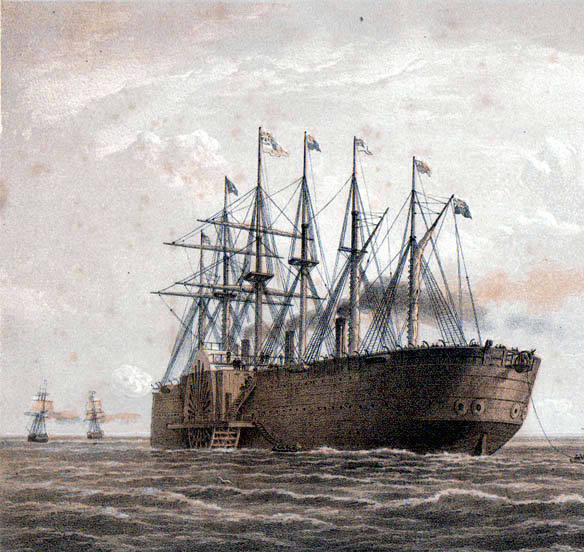

In [78]:
from IPython.display import Image, display
display(Image(filename = 'colorization/val/1/Victorian4.png'))

In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader

import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

In [32]:
use_gpu = torch.cuda.is_available()

In [33]:
class ColorizationNet(nn.Module):
    def __init__(self, input_size = 128):
        super(ColorizationNet, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128
        
        #ResNet
        resnet = models.resnet18(num_classes = 365)

        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
        #Extracting midlevel features from ResNet-gray
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

        #Upsampling
        self.upsample = nn.Sequential(
            nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),
        )
    def forward(self, input):
        
        midlevel_features = self.midlevel_resnet(input)
        
        output = self.upsample(midlevel_features)
        return output

In [34]:
model = ColorizationNet()

In [35]:
#Loss Function
criterion = nn.MSELoss()

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2, weight_decay = 0.0)

In [37]:
class GrayscaleImageFolder(datasets.ImageFolder):  
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)
            img_lab = rgb2lab(img_original)
            img_lab = (img_lab + 128) / 255
            img_ab = img_lab[:, :, 1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
            img_original = rgb2gray(img_original)
            img_original = torch.from_numpy(img_original).unsqueeze(0).float()
        if self.target_transform is not None: 
            target = self.target_transform(target)
        return img_original, img_ab, target

In [58]:
# Training
train_transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder("",train_transform)
train_loader = DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder("D:\the_basics\Jupyter\val\v\2" , val_transform)
val_loader = DataLoader(val_imagefolder, batch_size=64, shuffle=True)

In [39]:
#Healper Fucntion
class AverageMeter(object):
    
    def __init__(self):
        self.reset()
    def resest(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val+ n
        self.count += n
        self.avg = self.sum / self.count
        
    def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
        
        plt.clf() #clear mmatplotlib
        color_image = torch.cat((grayscale_input, ab_input), 0).numpy() #combine channels
        color_image = color_image.transpose((1, 2, 0)) #rescale matplotlib
        color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
        color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128
        color_image = lab2rgb(color_image.astype(np.float64))
        grayscale_input = grayscale_input.squeeze().numpy()
        if save_path is not None and save_name is not None:
            plt.imsave(arr = grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
            plt.imsave(arr = color_input, fname='{}{}'.format(save_path['colorized'], save_name))

In [40]:
def validate(val_loader, model, criterion, save_images, epoch):
    model.eval()
    
    batch_time, date_time, losses = AverageMeter(), AverageMeter(), AverageMeter()
    
    end = time.time()
    already_saved_images = False
    for i, (input_gray, input_ab, target) in enumerate(val_loader):
        date_time.update(time.time() - end)
        
        #Use GPU
        if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target().cuda()
            
        output_ab = model(input_gray)
        loss = criterion(output_ab, intput_ab)
        losses.update(loss.item(), input_gray.size(0))
        
        if save_images and not already_saved_images:
            already_saved_images = True
            for j in range(min(len(output_ab), 10)):
                save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
                save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
                to_rgb(input_gray[j].cpu(), ab_input = output_ab[j].detach().cpuu, save_path = save_path, save_name = save_name)
                
        batch_time.update(time.time() - end)
        end = time.time()
        
        if i % 25 == 0:
            print('Validate: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                  i, len(val_loader), batch_time = batch_time, loss = losses))
    
    print('Finished Validation.')
    return losses.avg

In [41]:
def train(train_loader, model, criterion, optimizer, epoch):
    print('Starting training epoch {}'.format(epoch))
    model.train()
    
    batch_time, date_time, losses = AverageMeter(), AverageMeter(), AverageMeter()
    
    end = time.time()
    for i, (input_gray, input_ab, target) in enumerate(train_loader):
        
        if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target().cuda()
        
        data_time.update(time.time() - end)
    
        output_ab = model(input_gray)
        loss = criterion(output_ab, intput_ab)
        losses.update(loss.item(), input_gray.size(0))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time.update(time.time() - end)
        end = time.time()
        
        if i % 25 == 0:
            print('Validate: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                      epoch, i, len(train_loader), batch_time = batch_time,
                      data_time = data_time, loss = losses))
        
    print('Finished training epoch {}'.format(epoch))
    

In [42]:
if use_gpu:
    criterion = criterion.cuda()
    model = model.cuda()

In [43]:
os.makedirs('outputs/color', exist_ok = True)
os.makedirs('outputs/gray', exist_ok = True)
os.makedirs('checkpoints', exist_ok = True)
save_images = True
best_losses = 1e10
epochs = 100

In [59]:
# #Train model
for epoch in range(epochs):
    train(train_loader, model, criterion, optimizer, epoch)
    with torch.no_grad():
        losses = validate(val_loader, model, criterion, save_images, epoch)
        
    if losses < est_losses:
        best_losses = losses
        torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1, losses))
        

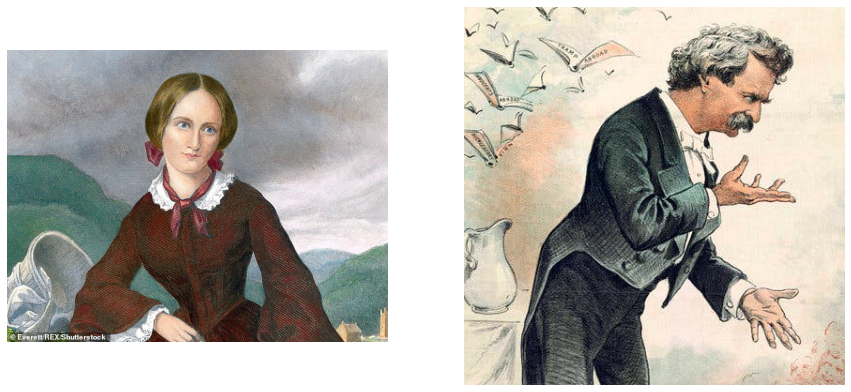

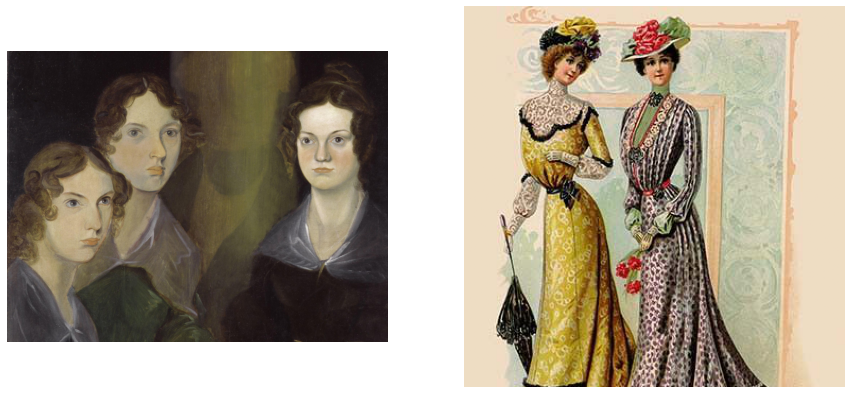

In [64]:
import matplotlib.image as mpimg
image_pairs = [('images/test/3/Victorian326.png', 'images/test/3/Victorian360.png'),
               ('images/test/3/Victorian323.png', 'images/test/3/Victorian324.png')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()
